In [2]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

2.4.1
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8kojkoah
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-8kojkoah
  Resolved https://github.com/tensorflow/docs to commit 2e0e4a5f3521a22d0d9fa3dd832a42d1d71be283
  Preparing metadata (setup.py) ... done


  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=182589 sha256=de80423f4e7740d3b7fb34ae0ff53b7e3ad0ece57a5bea97416a3505647c26ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-9oyxm6n3/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
# gzip文件可以直接读取csv:tf.data.experimental.CsvDataset
FEATURES = 28

ds = tf.data.experimental.CsvDataset(gz, [float(), ] * (FEATURES + 1), compression_type='GZIP')


# CSV 读取器类会为每条记录返回一个标量列表。
# 下面的函数会将此标量列表重新打包为 (feature_vector, label) 对。
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

2023-03-27 20:22:19.252731: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-27 20:22:19.254071: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-27 20:22:19.298913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-27 20:22:19.300352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-27 20:22:19.301746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:3d:00.0 name: GeFo

In [4]:
# Tensorflow在大批量数据效率高，
# 不单独打包，
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
# take1:取第一个元素构建dataset
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])  # 只有一个数据

2023-03-27 20:23:29.882792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-27 20:23:29.915839: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


In [32]:
# 对于1000个样本进行验证、10000个样本进行训练
N_VALIDATION = int(1e3)
N_TARIN = int(1e4)
BUFFER_SIZE = int(1e4)  # buffer_size?
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TARIN // BATCH_SIZE
# 保存至cache，无需重复读取
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TARIN).cache()

# 创建批次，对训练集要进行shuffle, repeat
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [15]:
"""
深度学习中， 真正的挑战在于泛化而非拟合
要找到合适的模型大小，最好先使用相对较少的层和参数，
然后增加层的大小或添加新层，直到看到返回的验证损失逐渐减小。
"""
# 先从全连接层Dense作为baseline
# kf.keras.optimizers.schedules：训练过程中减少学习率
# 在1000个周期降至1/2，在2000个周期降至1/3
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.01,
                                                            decay_steps=STEP_PER_EPOCH*1000,
                                                            decay_rate=1,
                                                            staircase=False)

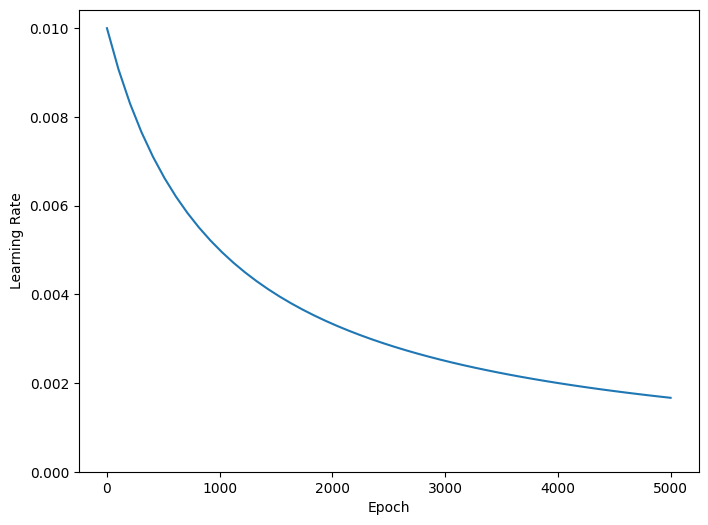

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [29]:
# 回调函数列表
def get_callbacks(name):
    return [
        # 每个周期打印一个.
        tfdocs.modeling.EpochDots(),
        # 是val_binary_crossentropy,不是val_loss!!
        # 因为在正则化时，每个权重的系数都会混入正则化组件，而binary_corssentropy不会混入该组件
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(log_dir=name),
    ]

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [30]:
# 每个模型采用相同的compile以及model.fit
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[
                     tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])
    model.summary()
    
    history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
    return history

In [46]:
#微模型，开始训练
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1)
])
size_histories={}
size_histories['Tiny'] = compile_and_fit(tiny_model,'TensorBoard/Overfit/Tiny')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'pos

2023-03-27 21:26:22.882347: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:26:22.882395: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:26:22.882610: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:26:22.882637: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-03-27 21:26:22.882660: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2023-03-27 21:26:23.604118: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:26:23.604149: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:26:23.604235: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:26:23.674114: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-03-27 21:26:23.674194: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:26:23.679274: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-03-27 21:26:23.688810: I tensorflow

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch: 0, accuracy:0.4907,  binary_crossentropy:0.7708,  loss:0.7708,  val_accuracy:0.5390,  val_binary_crossentropy:0.6809,  val_loss:0.6809,  
....................................................................................................
Epoch: 100, accuracy:0.6675,  binary_crossentropy:0.5833,  loss:0.5833,  val_accuracy:0.6050,  val_binary_crossentropy:0.6098,  val

(0.5, 0.7)

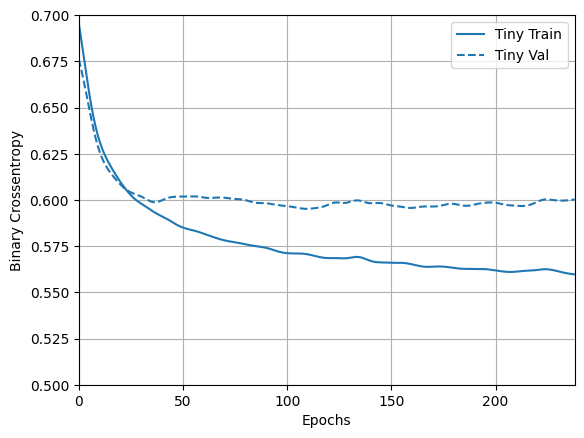

In [34]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [35]:
"""
小模型，检查时候超过小模型的表现
"""
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories['Small'] = compile_and_fit(small_model, 'TensorBoard/Overfit/Small')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

2023-03-27 21:06:37.848311: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:06:37.848350: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:06:37.848413: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:06:37.848437: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-03-27 21:06:37.848457: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2023-03-27 21:06:38.534329: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:06:38.534362: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:06:38.534398: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:06:38.605004: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-03-27 21:06:38.605084: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:06:38.610478: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-03-27 21:06:38.619564: I tensorflow

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch: 0, accuracy:0.4760,  binary_crossentropy:0.7065,  loss:0.7065,  val_accuracy:0.4740,  val_binary_crossentropy:0.6855,  val_loss:0.6855,  
....................................................................................................
Epoch: 100, accuracy:0.7042,  binary_crossentropy:0.5455,  loss:0.5455,  val_accuracy:0.6460,  val_binary_crossentropy:0.6062,  val

In [36]:
"""
大模型
"""
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])
size_histories['large'] = compile_and_fit(large_model, 'TensorBoard/Overfit/Big')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRA

2023-03-27 21:08:21.513502: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:08:21.513538: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:08:21.513592: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:08:21.513615: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-03-27 21:08:21.513635: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2023-03-27 21:08:22.406230: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:08:22.406263: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:08:22.406318: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:08:22.494737: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-03-27 21:08:22.494836: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:08:22.500079: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-03-27 21:08:22.509199: I tensorflow

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch: 0, accuracy:0.5007,  binary_crossentropy:19.7627,  loss:19.7627,  val_accuracy:0.4680,  val_binary_crossentropy:1.2450,  val_loss:1.2450,  
....................................................................................................
Epoch: 100, accuracy:0.7878,  binary_crossentropy:0.4117,  loss:0.4117,  val_accuracy:0.6310,  val_binary_crossentropy:0.8441,  v

Text(0.5, 0, 'Epochs [Log Scale]')

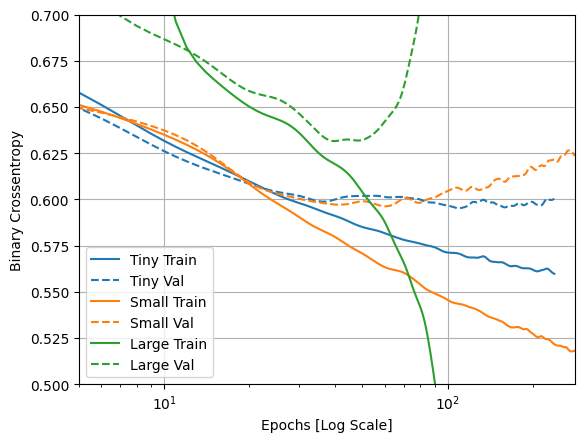

In [37]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [40]:
"""
防止过拟合-选择Tiny作为baseline
"""
logdir = pathlib.Path(tempfile.mkdtemp())/"Tensorboard/Overfit"
shutil.rmtree(logdir, ignore_errors=True)
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [47]:
"""
"权重正则化": 限制网络的复杂性，强制网络权重值只取较小值，使得权重分布更加"规则"。
"""
# 在大模型的基础上，加入l2正则化
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "TensorBoard/Overfit/regularizers/l2")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGR

2023-03-27 21:28:18.605952: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:28:18.606000: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:28:18.606090: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:28:18.606113: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-03-27 21:28:18.606135: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2023-03-27 21:28:19.553419: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:28:19.553454: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:28:19.553517: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:28:19.645521: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-03-27 21:28:19.645629: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:28:19.651178: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-03-27 21:28:19.661070: I tensorflow

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch: 0, accuracy:0.4779,  binary_crossentropy:1.3469,  loss:2.1606,  val_accuracy:0.4600,  val_binary_crossentropy:0.6903,  val_loss:1.3481,  
....................................................................................................
Epoch: 100, accuracy:0.6845,  binary_crossentropy:0.5747,  loss:0.5963,  val_accuracy:0.6370,  val_binary_crossentropy:0.6083,  val

(0.5, 0.7)

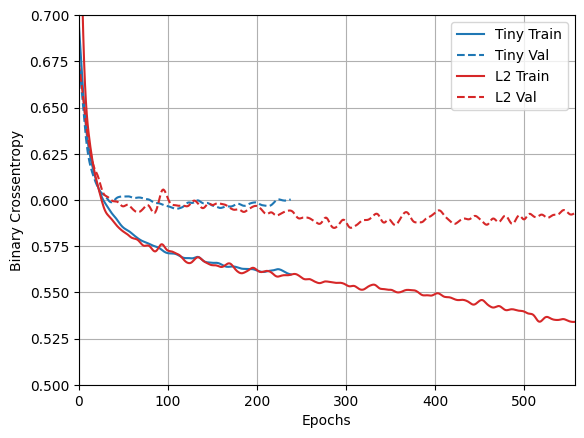

In [48]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [49]:
"""
添加随机失活:Dropout
"""
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "TensorBoard/Overfit/regularizers/dropout")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)             

2023-03-27 21:35:13.050423: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:35:13.050514: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:35:13.050677: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:35:13.050703: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-03-27 21:35:13.050727: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2023-03-27 21:35:13.923934: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-27 21:35:13.923967: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-27 21:35:13.924063: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:35:14.022324: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-03-27 21:35:14.022420: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2023-03-27 21:35:14.025253: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-03-27 21:35:14.032966: I tensorflow

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch: 0, accuracy:0.5115,  binary_crossentropy:6.7425,  loss:6.7425,  val_accuracy:0.4570,  val_binary_crossentropy:0.7597,  val_loss:0.7597,  
....................................................................................................
Epoch: 100, accuracy:0.5871,  binary_crossentropy:0.6562,  loss:0.6562,  val_accuracy:0.6290,  val_binary_crossentropy:0.6550,  val